# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-25000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_residual_stride_25000'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        return x

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(32, 64, stride=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 128, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc1 = nn.Linear(8 * 8 * 128, embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            ResidualBlock(64, 32),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters, calculate_metrics, save_to_file, load_from_file, print_matrix, plot_conf_matrix

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    metrics = calculate_metrics(model, testset)
    print_matrix(metrics)
    plot_conf_matrix(metrics['conf_matrix'])
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 832615
Epoch [1/20], Train Loss: 0.1574, Test Loss: 0.1316
Epoch [2/20], Train Loss: 0.1182, Test Loss: 0.1147
Epoch [3/20], Train Loss: 0.1106, Test Loss: 0.1122
Epoch [4/20], Train Loss: 0.1046, Test Loss: 0.1071
Epoch [5/20], Train Loss: 0.1019, Test Loss: 0.1028
Epoch [6/20], Train Loss: 0.1002, Test Loss: 0.1019
Epoch [7/20], Train Loss: 0.0987, Test Loss: 0.1008
Epoch [8/20], Train Loss: 0.0975, Test Loss: 0.1000
Epoch [9/20], Train Loss: 0.0959, Test Loss: 0.1013
Epoch [10/20], Train Loss: 0.0951, Test Loss: 0.0970
Epoch [11/20], Train Loss: 0.0934, Test Loss: 0.0952
Epoch [12/20], Train Loss: 0.0928, Test Loss: 0.0955
Epoch [13/20], Train Loss: 0.0921, Test Loss: 0.0942
Epoch [14/20], Train Loss: 0.0918, Test Loss: 0.0949
Epoch [15/20], Train Loss: 0.0912, Test Loss: 0.0941
Epoch [16/20], Train Loss: 0.0909, Test Loss: 0.0936
Epoch [17/20], Train Loss: 0.0906, Test Loss: 0.0935
Epoch [18/20], Train Loss: 0.0904, Test Loss: 0.0933
Epoch [19/20], Train Loss:

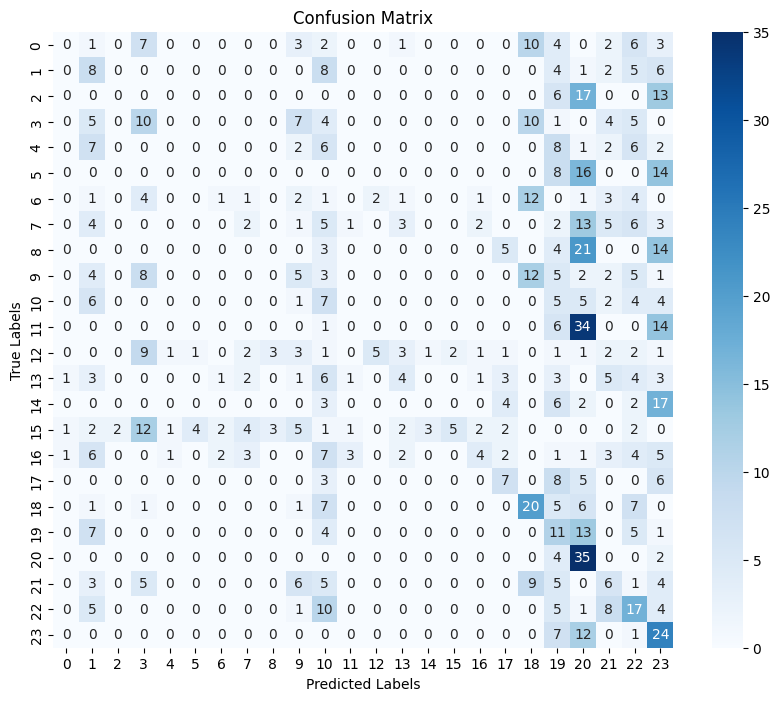

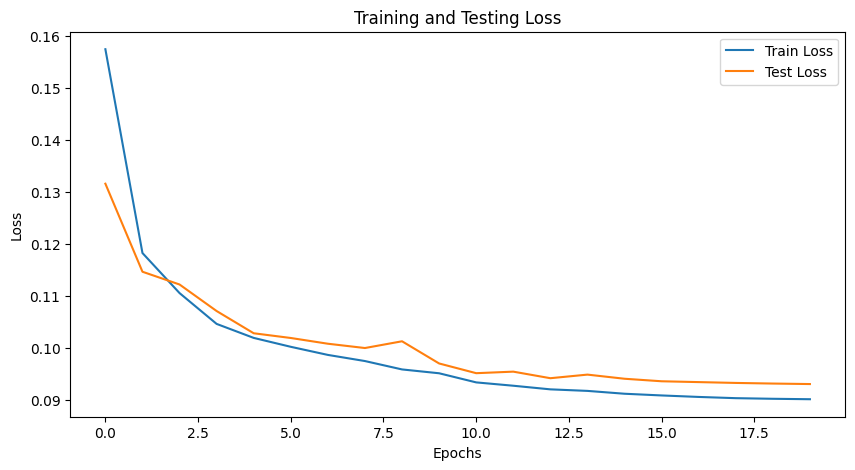

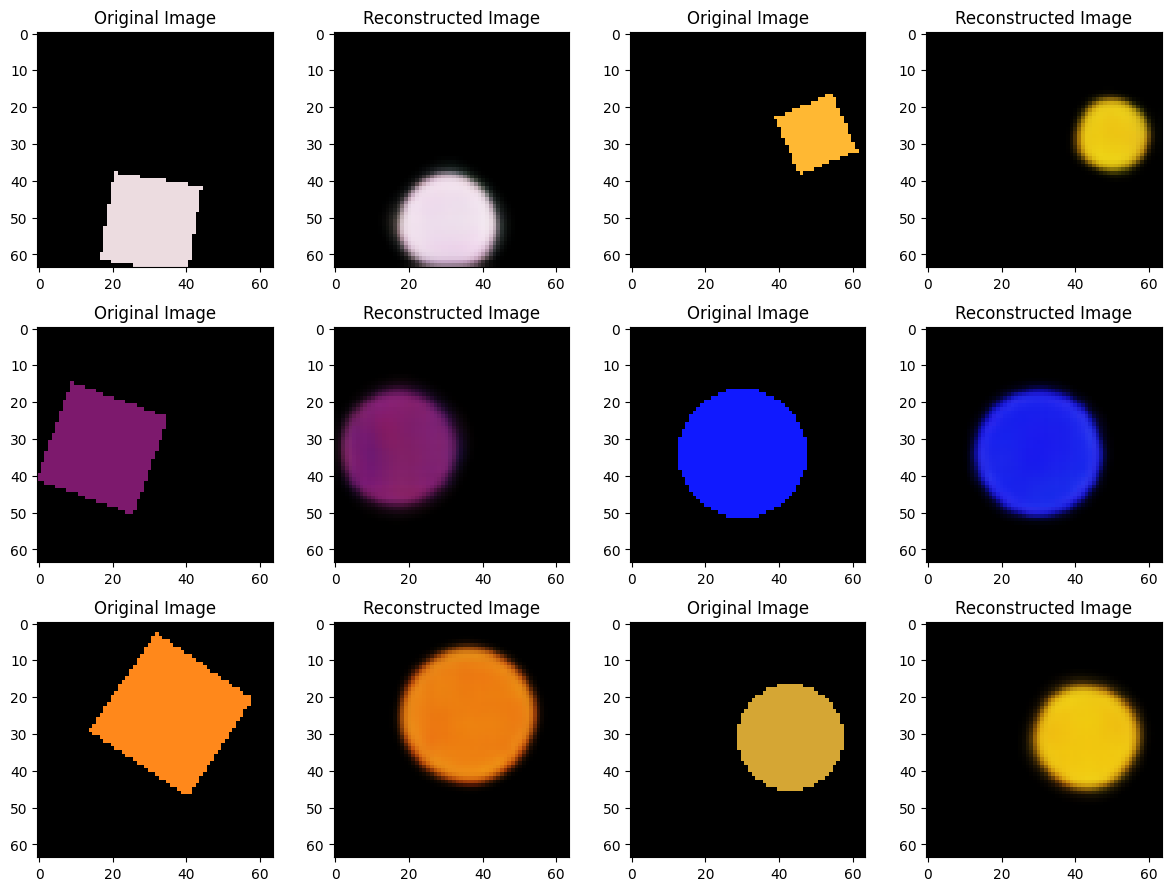

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 898155
Epoch [1/20], Train Loss: 0.1470, Test Loss: 0.1118
Epoch [2/20], Train Loss: 0.0991, Test Loss: 0.0944
Epoch [3/20], Train Loss: 0.0903, Test Loss: 0.0902
Epoch [4/20], Train Loss: 0.0870, Test Loss: 0.0875
Epoch [5/20], Train Loss: 0.0843, Test Loss: 0.0851
Epoch [6/20], Train Loss: 0.0822, Test Loss: 0.0835
Epoch [7/20], Train Loss: 0.0805, Test Loss: 0.0815
Epoch [8/20], Train Loss: 0.0789, Test Loss: 0.0806
Epoch [9/20], Train Loss: 0.0776, Test Loss: 0.0792
Epoch [10/20], Train Loss: 0.0765, Test Loss: 0.0787
Epoch [11/20], Train Loss: 0.0754, Test Loss: 0.0772
Epoch [12/20], Train Loss: 0.0747, Test Loss: 0.0763
Epoch [13/20], Train Loss: 0.0740, Test Loss: 0.0760
Epoch [14/20], Train Loss: 0.0735, Test Loss: 0.0764
Epoch [15/20], Train Loss: 0.0730, Test Loss: 0.0751
Epoch [16/20], Train Loss: 0.0726, Test Loss: 0.0745
Epoch [17/20], Train Loss: 0.0724, Test Loss: 0.0743
Epoch [18/20], Train Loss: 0.0722, Test Loss: 0.0741
Epoch [19/20], Train Loss:

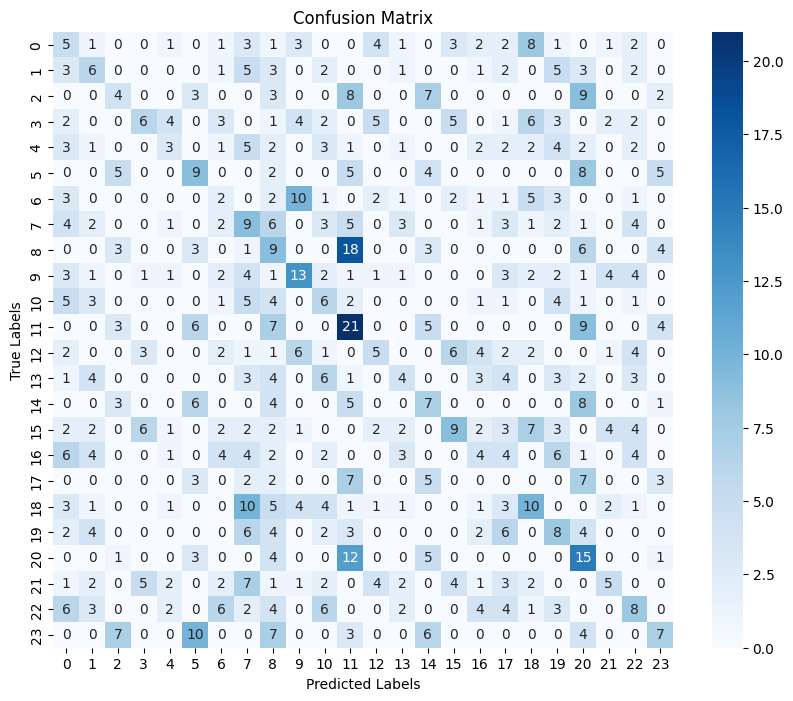

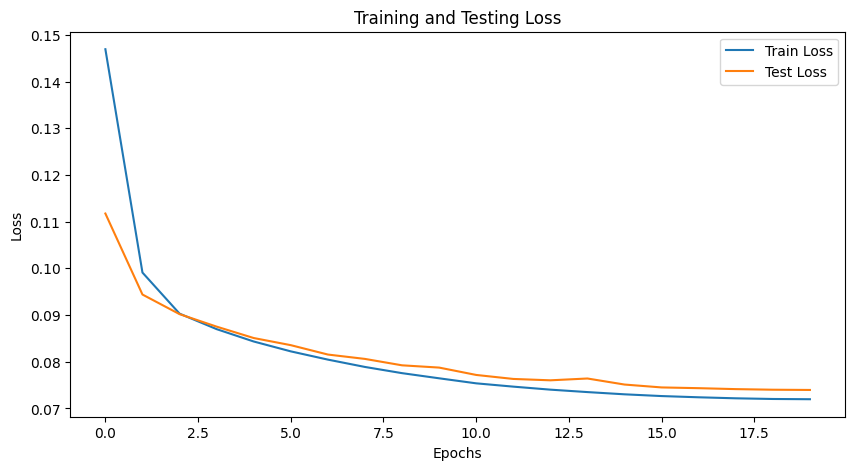

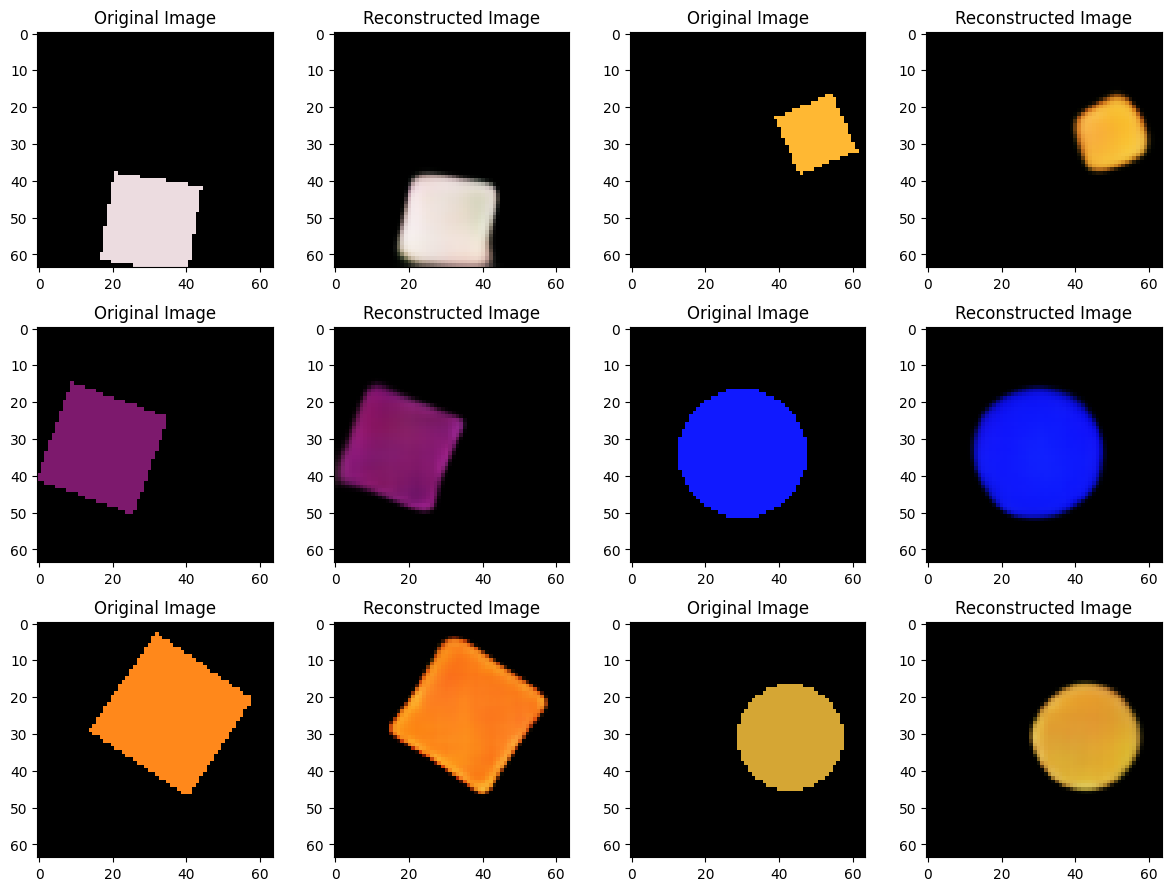

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1029235
Epoch [1/20], Train Loss: 0.1390, Test Loss: 0.1041
Epoch [2/20], Train Loss: 0.0902, Test Loss: 0.0857
Epoch [3/20], Train Loss: 0.0814, Test Loss: 0.0813
Epoch [4/20], Train Loss: 0.0778, Test Loss: 0.0788
Epoch [5/20], Train Loss: 0.0754, Test Loss: 0.0784
Epoch [6/20], Train Loss: 0.0740, Test Loss: 0.0756
Epoch [7/20], Train Loss: 0.0728, Test Loss: 0.0745
Epoch [8/20], Train Loss: 0.0720, Test Loss: 0.0743
Epoch [9/20], Train Loss: 0.0713, Test Loss: 0.0731
Epoch [10/20], Train Loss: 0.0707, Test Loss: 0.0728
Epoch [11/20], Train Loss: 0.0702, Test Loss: 0.0722
Epoch [12/20], Train Loss: 0.0698, Test Loss: 0.0721
Epoch [13/20], Train Loss: 0.0694, Test Loss: 0.0717
Epoch [14/20], Train Loss: 0.0691, Test Loss: 0.0717
Epoch [15/20], Train Loss: 0.0688, Test Loss: 0.0713
Epoch [16/20], Train Loss: 0.0686, Test Loss: 0.0709
Epoch [17/20], Train Loss: 0.0685, Test Loss: 0.0709
Epoch [18/20], Train Loss: 0.0683, Test Loss: 0.0707
Epoch [19/20], Train Loss

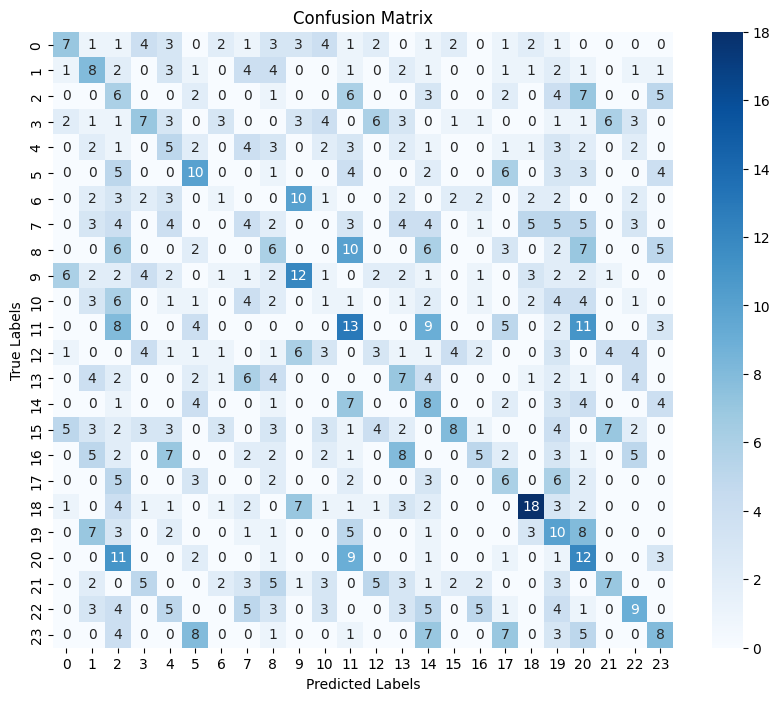

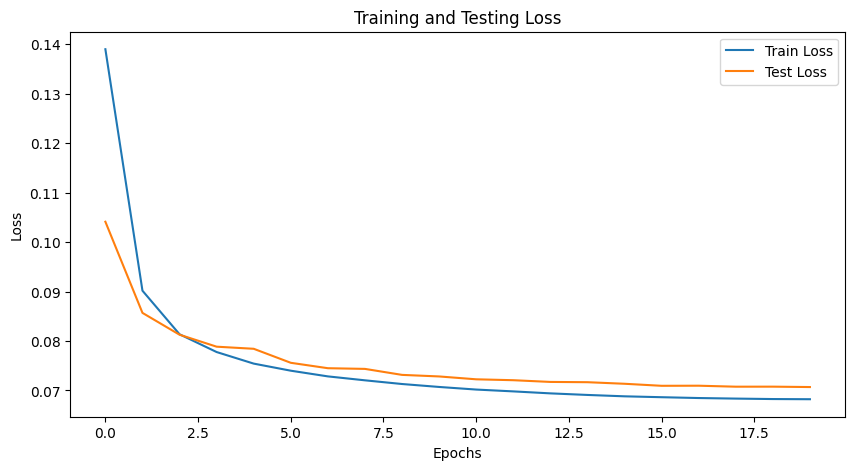

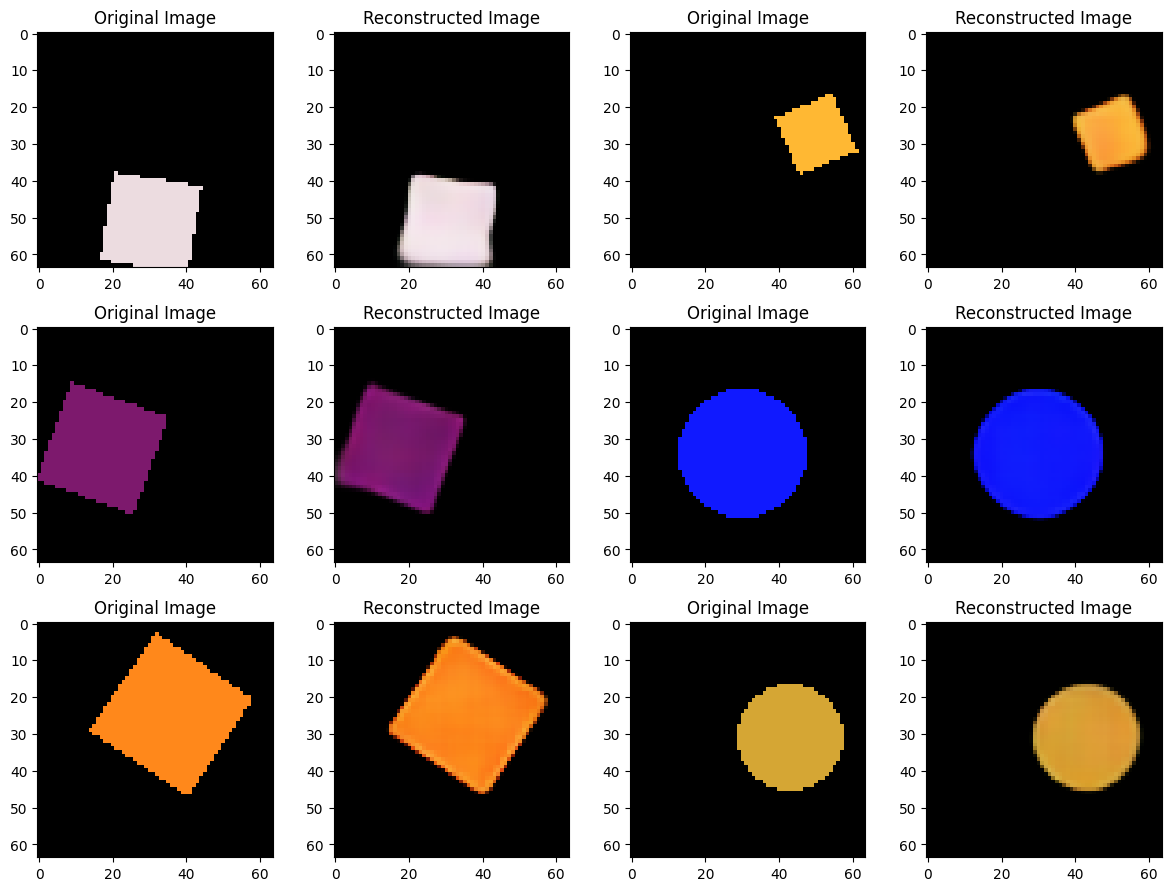

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1291395
Epoch [1/20], Train Loss: 0.1335, Test Loss: 0.0947
Epoch [2/20], Train Loss: 0.0850, Test Loss: 0.0819
Epoch [3/20], Train Loss: 0.0782, Test Loss: 0.0782
Epoch [4/20], Train Loss: 0.0751, Test Loss: 0.0761
Epoch [5/20], Train Loss: 0.0733, Test Loss: 0.0748
Epoch [6/20], Train Loss: 0.0722, Test Loss: 0.0744
Epoch [7/20], Train Loss: 0.0712, Test Loss: 0.0748
Epoch [8/20], Train Loss: 0.0706, Test Loss: 0.0726
Epoch [9/20], Train Loss: 0.0699, Test Loss: 0.0727
Epoch [10/20], Train Loss: 0.0694, Test Loss: 0.0719
Epoch [11/20], Train Loss: 0.0690, Test Loss: 0.0717
Epoch [12/20], Train Loss: 0.0686, Test Loss: 0.0711
Epoch [13/20], Train Loss: 0.0683, Test Loss: 0.0709
Epoch [14/20], Train Loss: 0.0680, Test Loss: 0.0707
Epoch [15/20], Train Loss: 0.0678, Test Loss: 0.0705
Epoch [16/20], Train Loss: 0.0677, Test Loss: 0.0702
Epoch [17/20], Train Loss: 0.0675, Test Loss: 0.0701
Epoch [18/20], Train Loss: 0.0674, Test Loss: 0.0700
Epoch [19/20], Train Loss

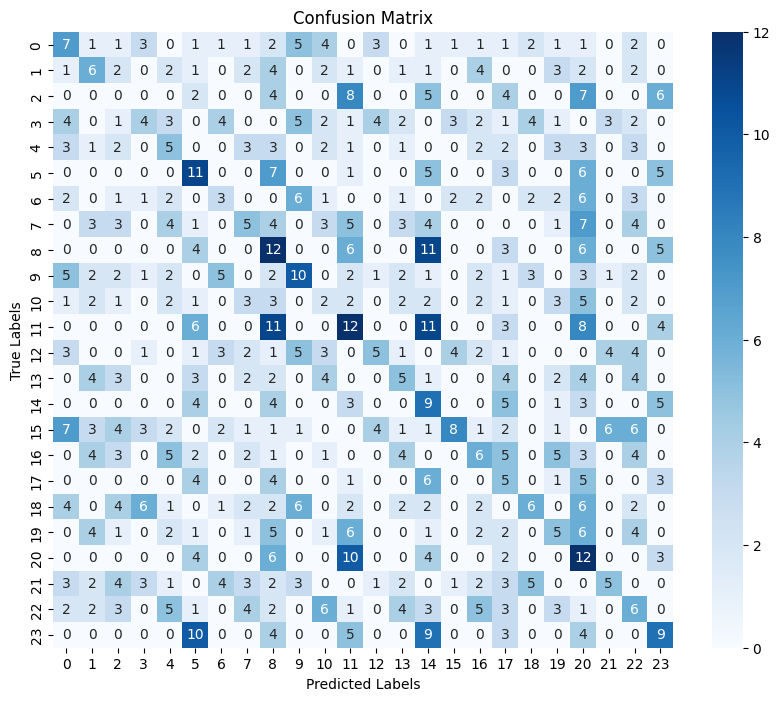

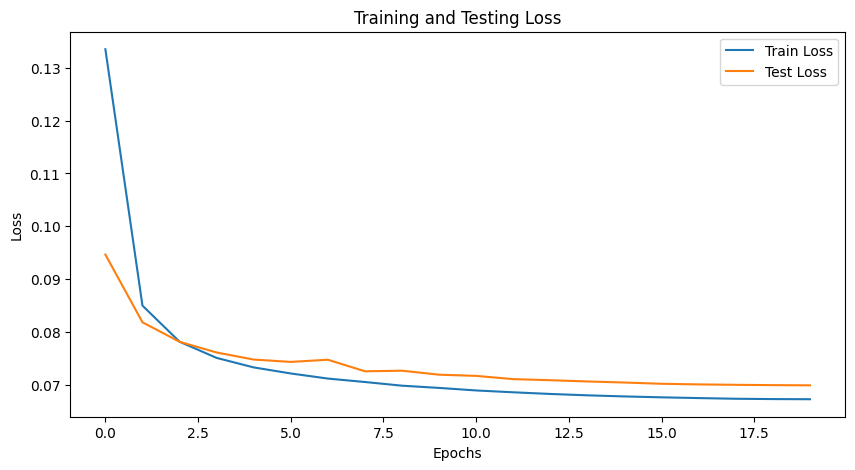

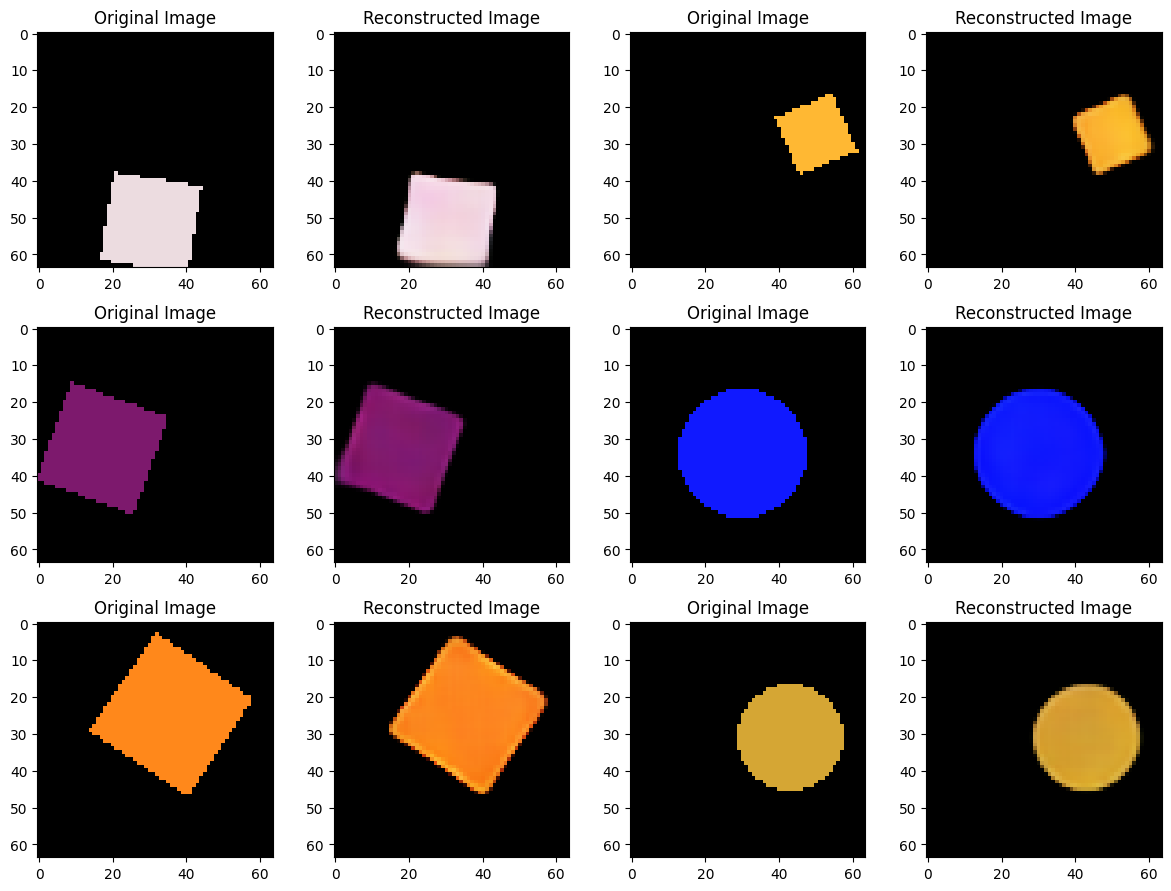

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1815715
Epoch [1/20], Train Loss: 0.1301, Test Loss: 0.0886
Epoch [2/20], Train Loss: 0.0811, Test Loss: 0.0801
Epoch [3/20], Train Loss: 0.0758, Test Loss: 0.0769
Epoch [4/20], Train Loss: 0.0735, Test Loss: 0.0753
Epoch [5/20], Train Loss: 0.0720, Test Loss: 0.0742
Epoch [6/20], Train Loss: 0.0710, Test Loss: 0.0730
Epoch [7/20], Train Loss: 0.0700, Test Loss: 0.0721
Epoch [8/20], Train Loss: 0.0694, Test Loss: 0.0716
Epoch [9/20], Train Loss: 0.0689, Test Loss: 0.0713
Epoch [10/20], Train Loss: 0.0684, Test Loss: 0.0707
Epoch [11/20], Train Loss: 0.0680, Test Loss: 0.0706
Epoch [12/20], Train Loss: 0.0677, Test Loss: 0.0704
Epoch [13/20], Train Loss: 0.0674, Test Loss: 0.0701
Epoch [14/20], Train Loss: 0.0672, Test Loss: 0.0698
Epoch [15/20], Train Loss: 0.0670, Test Loss: 0.0696
Epoch [16/20], Train Loss: 0.0668, Test Loss: 0.0694
Epoch [17/20], Train Loss: 0.0667, Test Loss: 0.0694
Epoch [18/20], Train Loss: 0.0666, Test Loss: 0.0693
Epoch [19/20], Train Loss

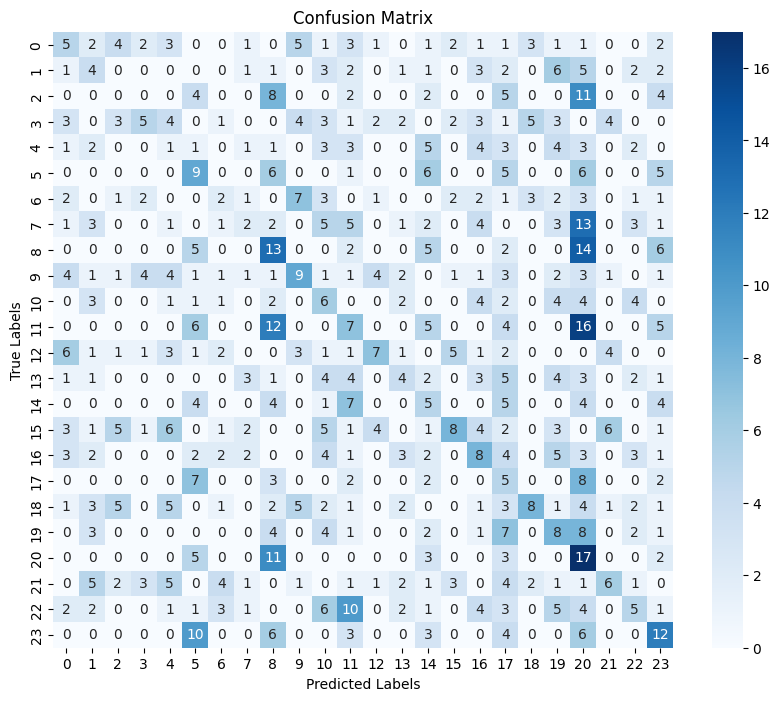

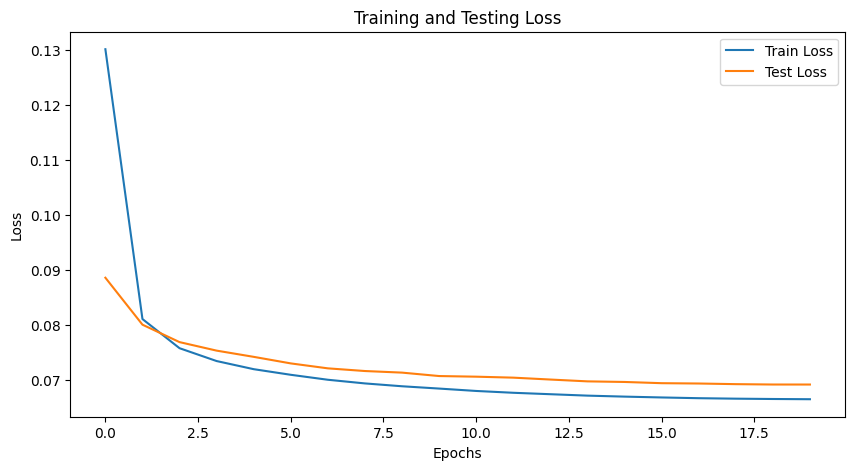

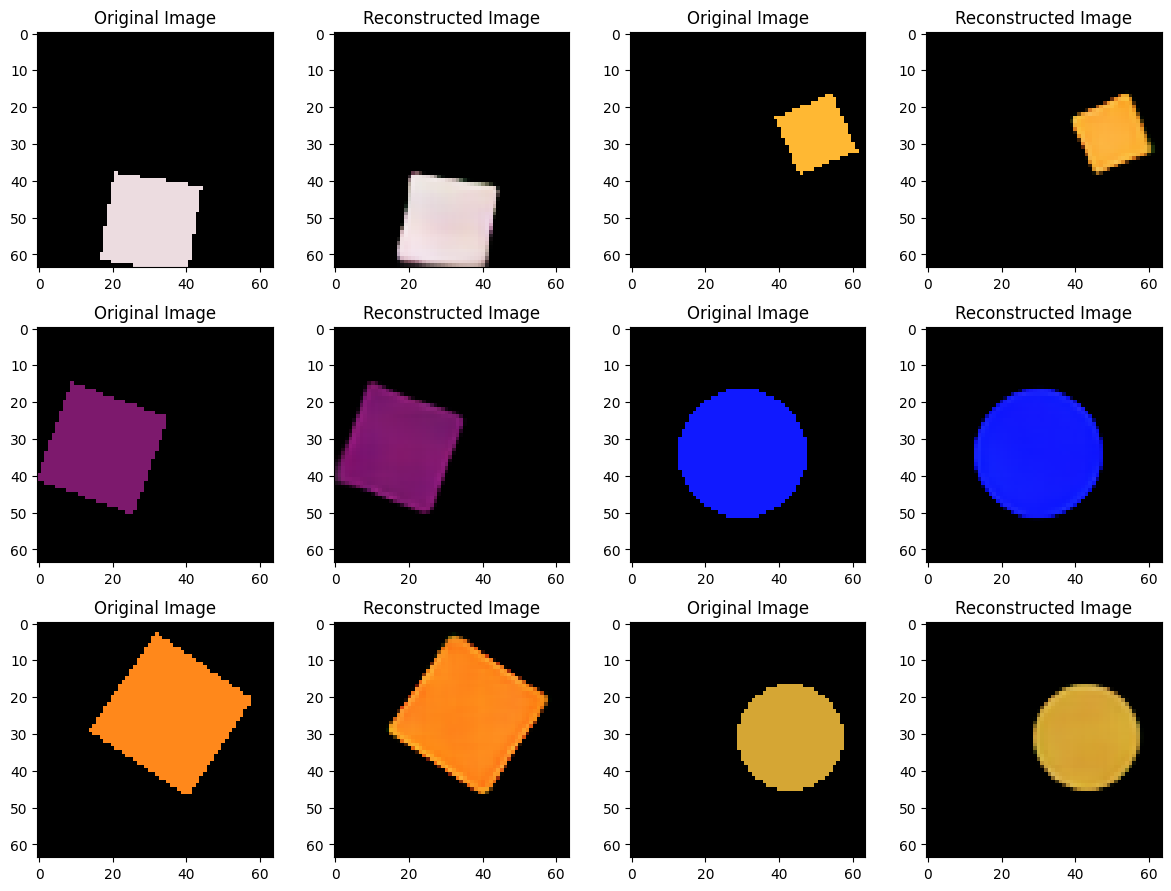

(Autoencoder(
   (encoder): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
     )
     (1): Dropout(p=0.1, inplace=False)
     (2): ResidualBlock(
       (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
     )
     (3): Dropout(p=0.1, inplace=False)
     (4): ResidualBlock(
       (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (relu): ReLU()
       (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
     )
     (5): Dropout

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)